# Syllables Analysis & Derégnaucourt replication

This notebook contains statistical analyses done by Derégnaucourt et al. (2005). Our goal is to reproduce the results of this paper.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from copy import deepcopy
from os.path import join, isdir
import json
import pandas as pd
import pickle
from scipy.io import wavfile
from syllable_cluster import *

from ipywidgets.widgets import FloatProgress
from IPython.display import display

import sys

sys.path.append('../model')

from song_model import SongModel

sns.set_palette('colorblind')
%matplotlib inline

Extract the data from all the bird in the simulation.

In [2]:
progress = FloatProgress(min=0, max=1)
display(progress)
main_path = '../model/res/diversity_170518_165814/seed{}+big_ba+on_alpha_silence_beta+prior_amp_entropy+super_slow_dev+500_replay+100_conc+3_day_conc+500_diversity_th'
all_dat = []

for seed in range(40):
    if not  isdir(main_path.format(seed)):
        continue
    path = main_path.format(seed)
    cur_dat = syllables_from_run(path, force=False, progress=progress)
    cur_dat['bird'] = seed
    all_dat.append(cur_dat)
    seed += 1
all_dat = pd.concat(all_dat)

sr, tutor = wavfile.read(join(main_path.format(0), 'tutor.wav'))
tutor_syllables = extract_syllables_statistics(tutor)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [3]:
pad = 20

# Study dynamics of syllable progression

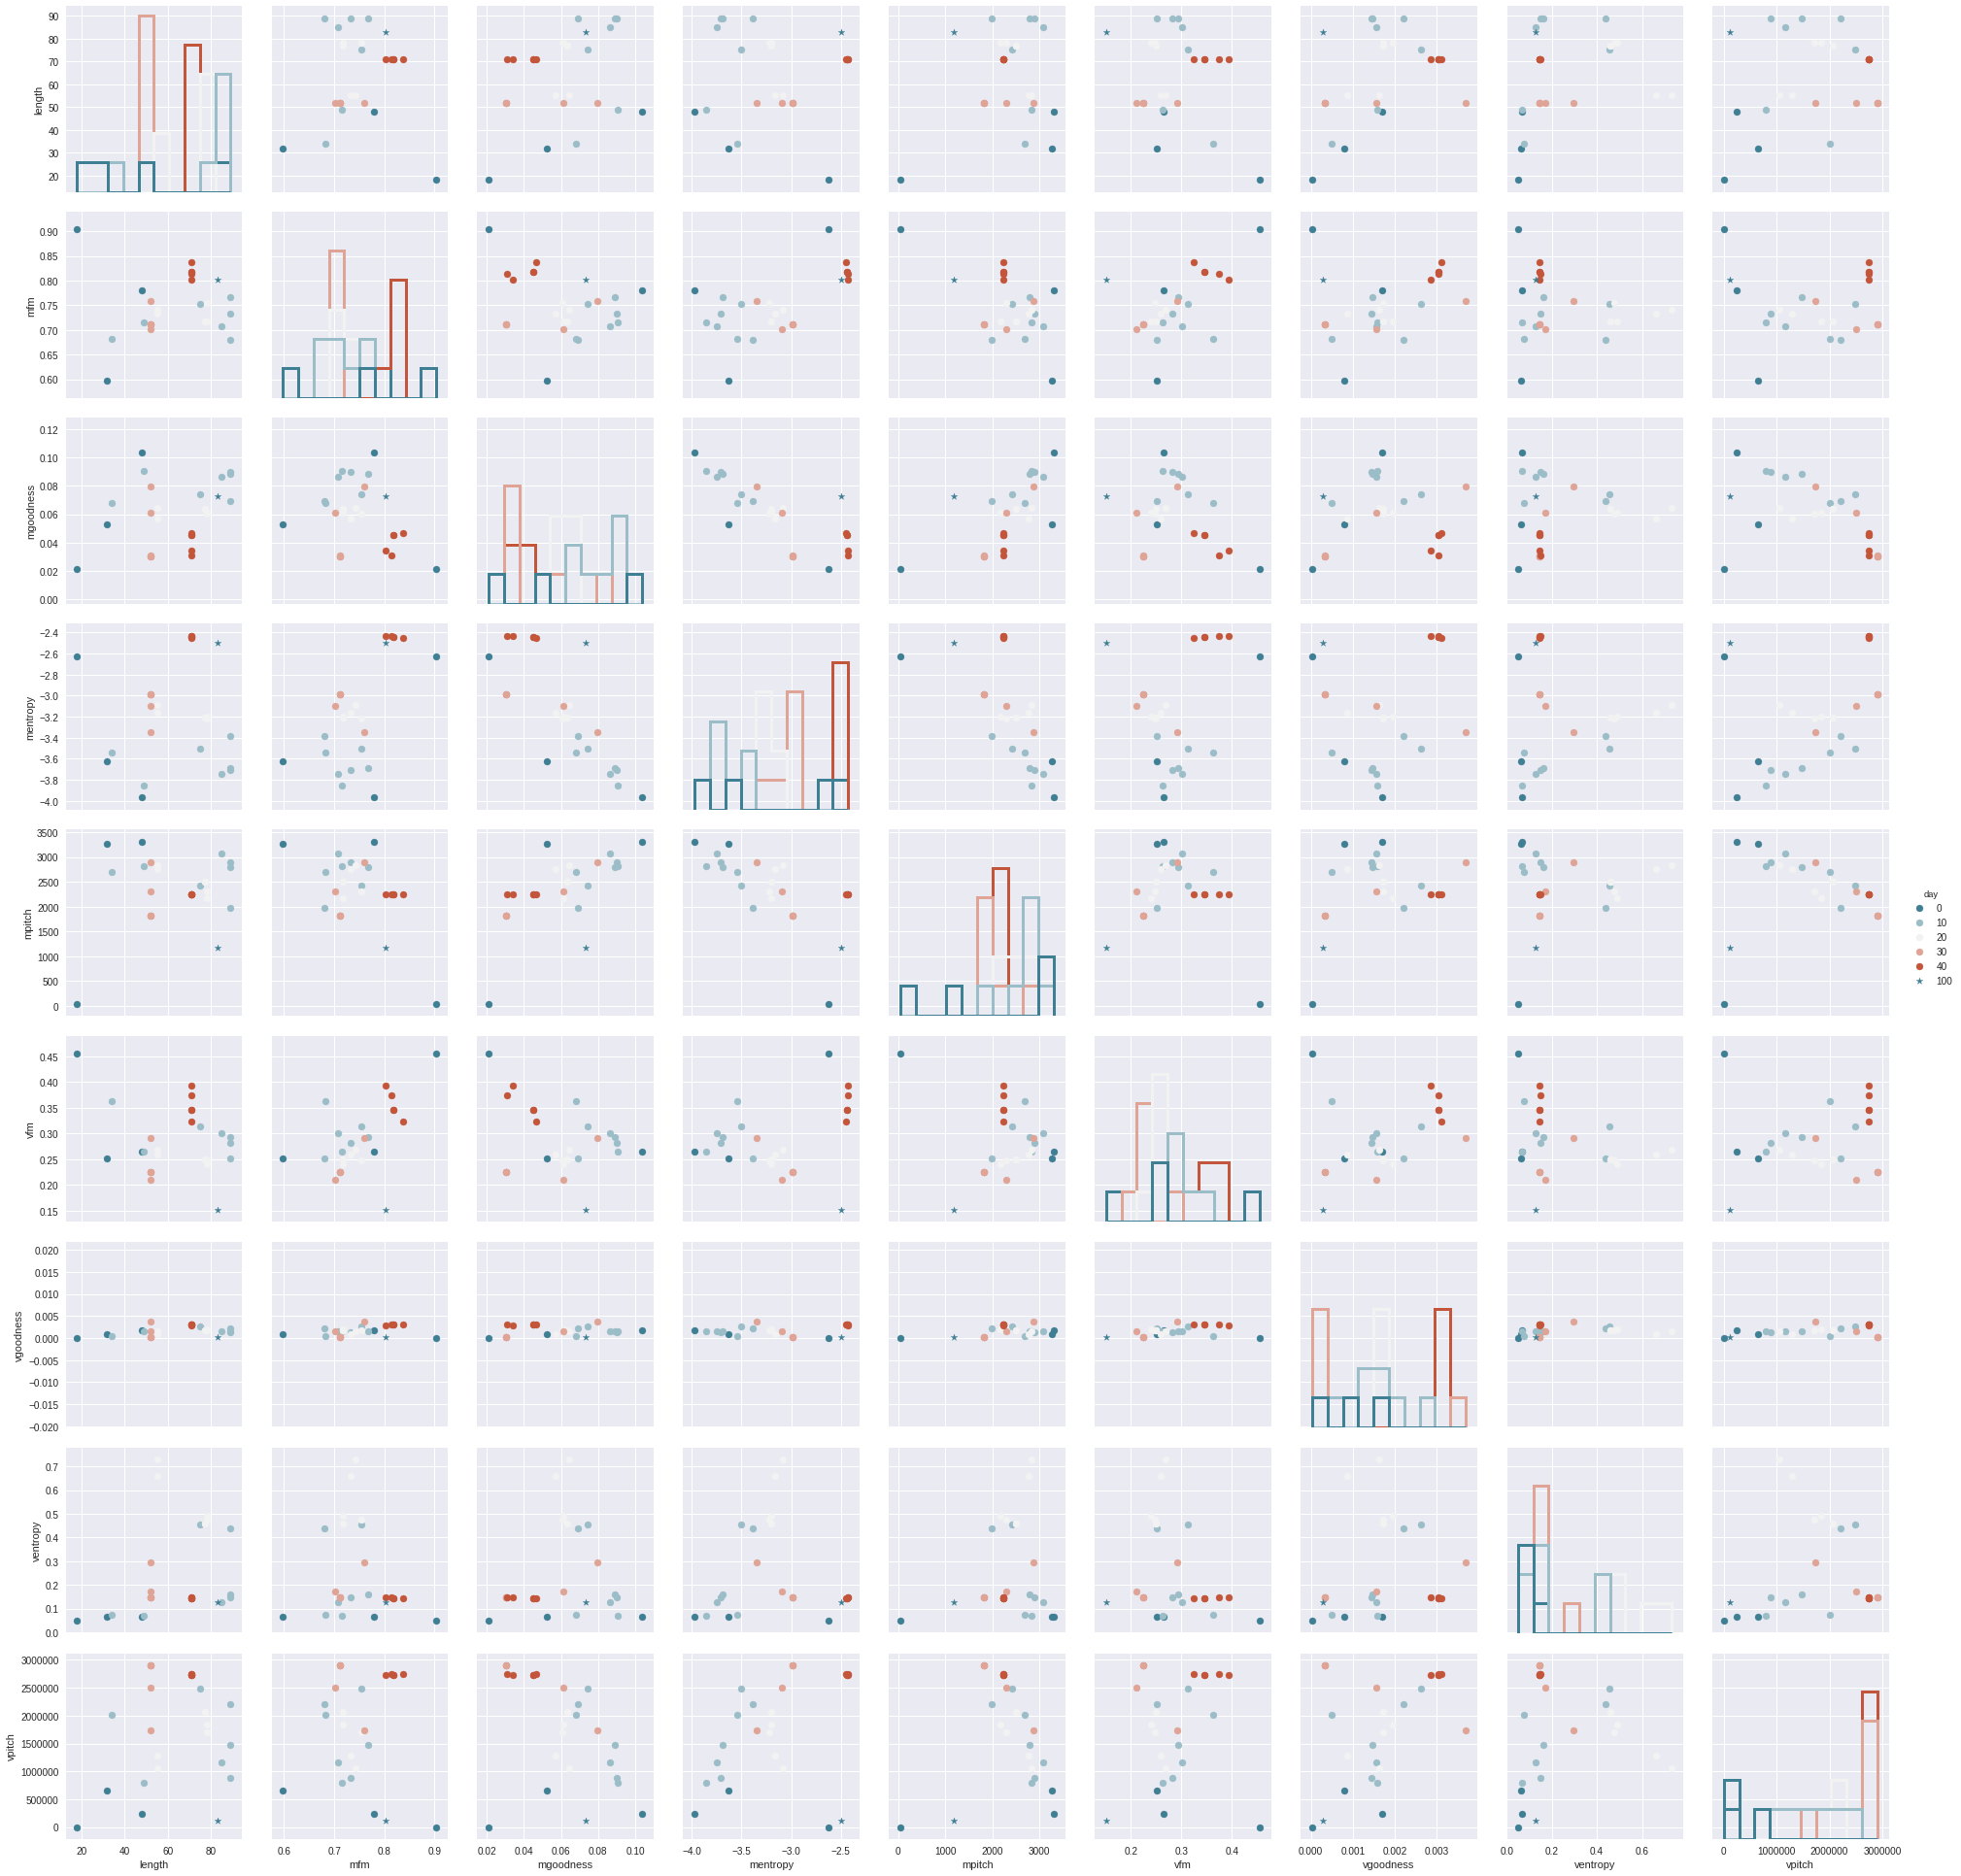

In [4]:
beg = tutor_syllables[0]['beg'] - pad
end = tutor_syllables[0]['end'] + pad
plot_dat = all_dat.query("((bird == {bird}) and ( \
                         (beg > {beg} and end < {end}) and day % 10 == 0))".format(
    bird=0,
    beg=tutor_syllables[0]['beg'] - pad,
    end=tutor_syllables[0]['end'] + pad
))
tutor_df = pd.DataFrame(tutor_syllables)
tutor_df['day'] = 100
plot_dat = pd.concat((plot_dat, tutor_df.query("beg > {beg} and end < {end}".format(beg=beg, end=end))))

g = sns.PairGrid(plot_dat, hue="day", hue_kws={'marker': ['o', 'o', 'o', 'o', 'o', '*']},
                 vars=['length', 'mfm', 'mgoodness', 'mentropy', 'mpitch',
                                            'vfm', 'vgoodness', 'ventropy', 'vpitch'], size=3, palette=sns.diverging_palette(220, 20, n=5))
g.map_diag(plt.hist, histtype="step", linewidth=3)
g.map_offdiag(plt.scatter, alpha=1)
#g.map_offdiag(sns.kdeplot, alpha=0.3)
g.add_legend()


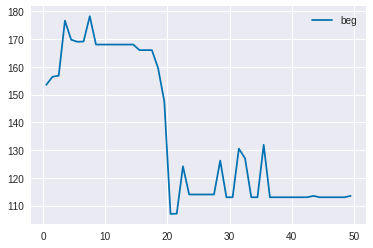

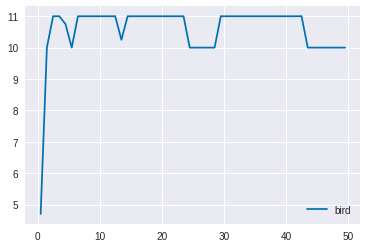

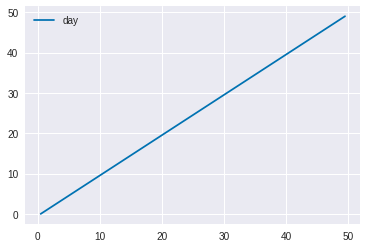

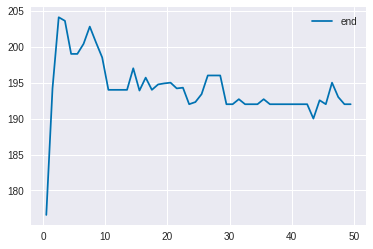

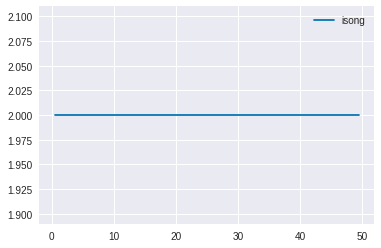

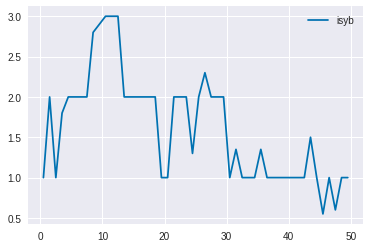

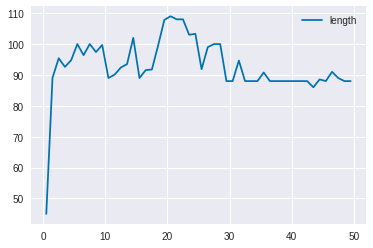

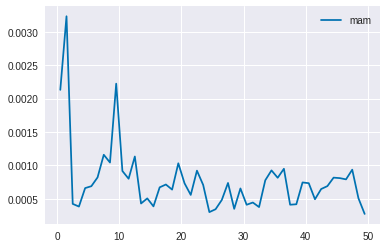

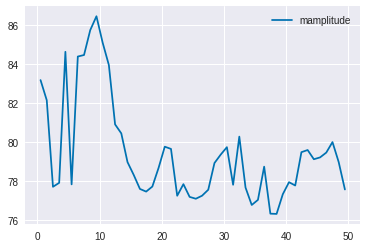

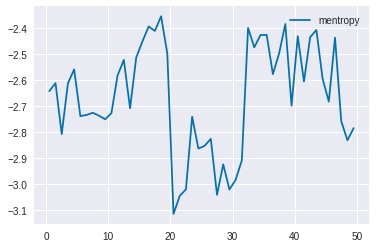

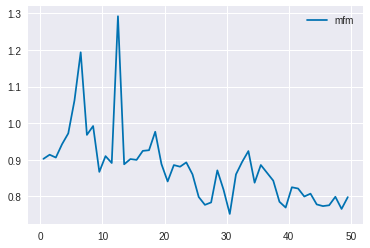

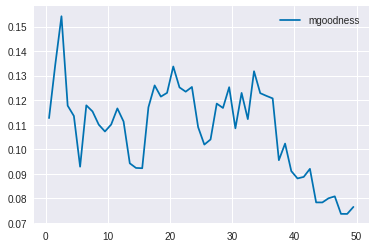

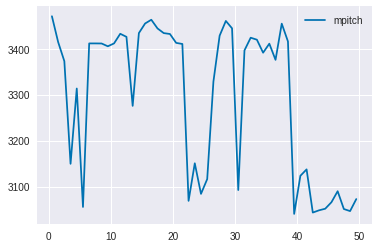

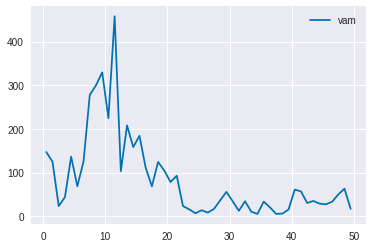

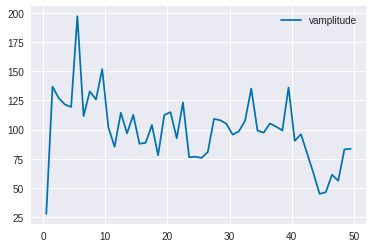

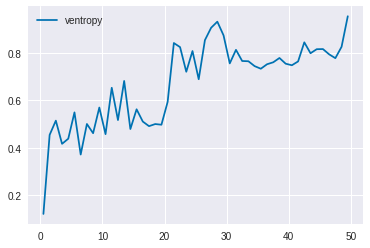

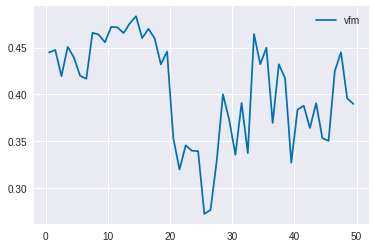

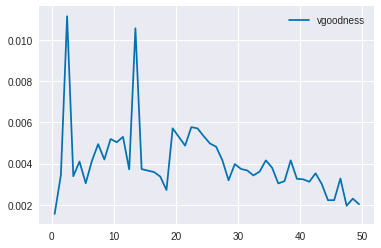

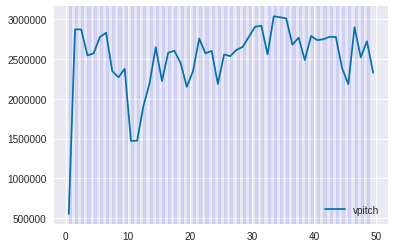

In [5]:
plt.figure(figsize=(14, 14))
med = all_dat.query('beg > {beg} and end < {end} and moment == "evening"'.format(
    beg=tutor_syllables[0]['beg'] - pad,
    end=tutor_syllables[0]['end'] + pad)).groupby('comb').quantile(0.95)
for item in med.keys():
    plt.figure()
    plt.plot(med[item], label=item)
    plt.legend()
for day in range(np.max(all_dat['day'])):
    plt.axvspan(day+0.5, day+1, color='b', alpha=0.1)

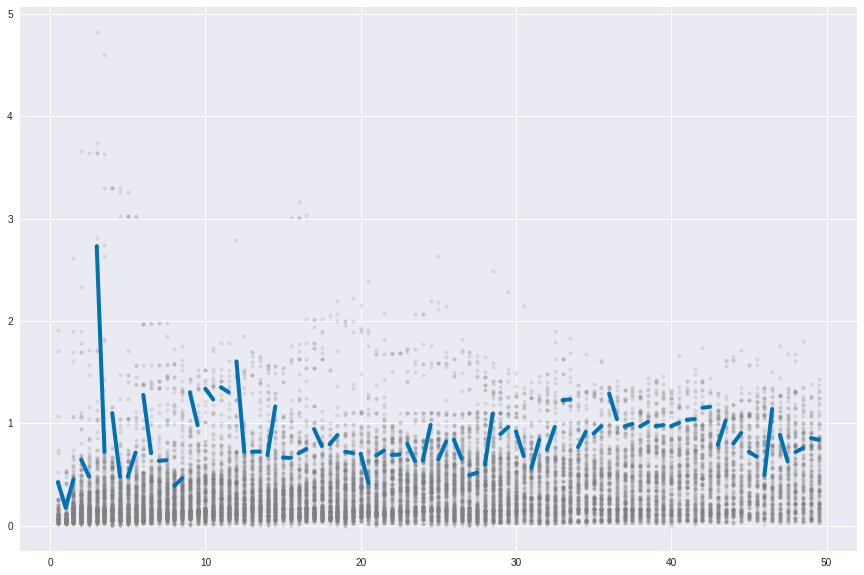

In [6]:
plt.figure(figsize=(15, 10))

feat = 'ventropy'

splitted = all_dat[all_dat.isyb == 3].groupby('comb')[feat].quantile(0.95)
for i in splitted.index:
    if i % 1 == 0:
        splitted.set_value(i + 0.75, np.nan)
splitted.sort_index(inplace=True)


plt.scatter(all_dat['comb'], all_dat[feat], marker='.', alpha=0.2, color="grey")
plt.plot(splitted, linewidth=4)

# Percent Change analysis

## Percent change absolute values

## Percent change signed values

In [16]:
all_changes = []

features = ['mentropy', 'mfm','mgoodness','vfm','ventropy','vgoodness']
features = ['ventropy']

# NIGHT

for bird_n, bird in all_dat.groupby('bird'):
    print(bird_n)
    for isyb, syllable in tutor_df.iterrows():
        print('syb:', isyb)
        beg = syllable['beg'] - pad
        end = syllable['end'] + pad
        objective = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(bird['day'].max()-1, beg=beg, end=end))
        if len(objective) == 0:
            print(isyb, 'ignored')
            continue
        for day in range(bird['day'].max()):
            first = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            last  = bird.query('day == {} and moment == "morning" and beg > {beg} and end < {end}'.format(day+1, beg=beg, end=end))
            if len(first) > 0 and len(last) > 0:
                sign = np.sign(last.median() - first.median()) * np.sign(objective.median() - first.median())[features]
                #display(sign)
                percent_change_all = (sign * (((last.median() - first.median()) / first.median() * 100).abs())[features])
                percent_change = percent_change_all.mean()
                if abs(percent_change) > 100:
                    print('*='*40)
                    #print(percent_change_all)
                    #print(first['ventropy'])
                    #print(last['ventropy'])
                all_changes.append({'day': day, 'isyb': isyb, 'bird': bird_n, 'percent_change':percent_change, 'cond': 'night'})

# DAY
for bird_n, bird in all_dat.groupby('bird'):
    print(bird_n)
    for isyb, syllable in tutor_df.iterrows():
        print('syb:', isyb)
        beg = syllable['beg'] - pad
        end = syllable['end'] + pad
        objective = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(bird['day'].max()-1, beg=beg, end=end))
        if len(objective) == 0:
            print(isyb, 'ignored')
            continue
        for day in range(bird['day'].max()):
            first = bird.query('day == {} and moment == "morning" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            last  = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            if len(first) > 0 and len(last) > 0:
                sign = np.sign(last.median() - first.median()) * np.sign(objective.median() - first.median())[features]
                #display(sign)
                percent_change_all = (sign * (((last.median() - first.median()) / first.median() * 100).abs())[features])
                percent_change = percent_change_all.mean()
                if abs(percent_change) > 100:
                    print('*='*40)
                all_changes.append({'day': day, 'isyb': isyb, 'bird': bird_n, 'percent_change':percent_change, 'cond': 'day'})


0
syb: 0
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 1
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 2
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 3
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 4
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 5
syb: 6
6 ignored
syb: 7
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 8
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
1
syb: 0
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 1
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 2
syb: 3
syb: 4
syb: 5
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 6
syb: 7
7 ignored
syb: 8
2
syb: 0
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*

In [17]:
change_df = pd.DataFrame(all_changes)
change_df["birdsyb"] = change_df['bird'] * 1000 + change_df['isyb']

change_df = change_df.groupby(('day', 'bird', 'cond')).mean()

change_df = pd.DataFrame(change_df.to_records()).query('-100 <percent_change < 100')


/home/ecoffet/.virtualenvs/birdsongs/lib/python3.5/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


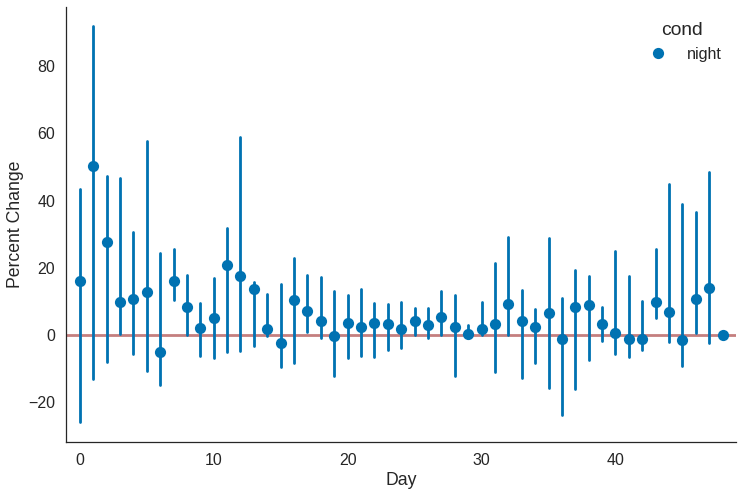

In [18]:
sns.set_context('poster')
sns.set_style('white')
plt.figure(figsize=(12, 8))
plt.axhline(0, c='darkred', alpha=0.5)
sns.tsplot(change_df.query('cond == "night"'), time='day', unit='bird', interpolate=False, value='percent_change', condition='cond', err_style='ci_bars', ci=95, estimator=np.nanmedian)
sns.despine()
plt.ylabel("Percent Change")
plt.xlabel('Day')
plt.savefig('per_det.svg')

In [19]:
all_changes_df = pd.DataFrame(all_changes)
night_pc = change_df.query('cond == "night"').groupby('bird').mean()

In [20]:
force = False
try:
    sim
except:
    force = True
if force:
    sim = []
    for i in night_pc.index:
        with open(join(main_path.format(i), 'data_cur.pkl'), 'rb') as f:
            songlog = pickle.load(f)
        root_data = [item[1] for item in songlog if item[0] == 'root']
        rd = pd.DataFrame(root_data)
        smodels = rd['songs'].iloc[-1]
        print(i, 'beg')
        sim.append(bsa.similarity(smodels[0].gen_sound(), tutor)['similarity'])
        print(i)

In [21]:
night_pc['percent_change_deterioration'] = -night_pc['percent_change']

night_pc['sim'] = sim

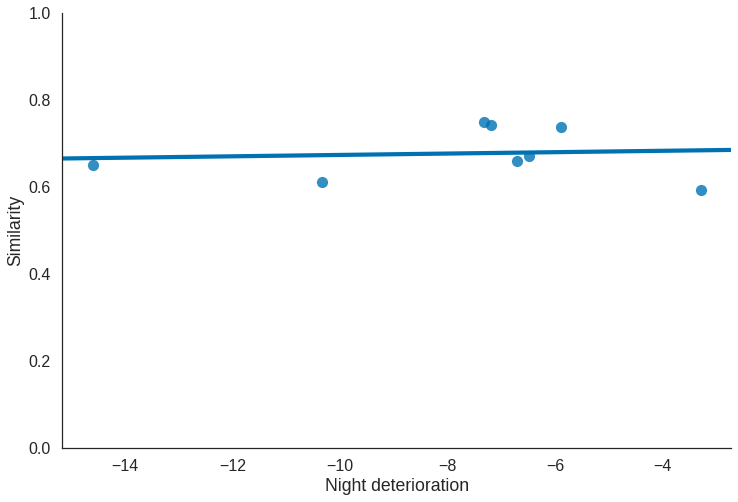

In [22]:
sns.set_context('poster')
sns.set_style('white')
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
sns.regplot(x="percent_change_deterioration", y='sim', data=night_pc, ax=ax, ci=0)
ax.set_xlabel('Night deterioration')
ax.set_ylabel('Similarity')
ax.set_ylim((0, 1))
sns.despine()

fig.savefig('corr.svg')

In [23]:
night_pc

,day,isyb,percent_change,birdsyb,percent_change_deterioration,sim
bird,,,,,,
0,24.957447,3.483789,5.895847,3.483789,-5.895847,0.738200
1,24.170213,3.273683,7.192007,1003.273683,-7.192007,0.742229
2,14.500000,4.062500,6.708894,2004.062500,-6.708894,0.660091
4,24.000000,3.187852,14.600498,4003.187852,-14.600498,0.650577
5,25.522727,4.193182,3.299911,5004.193182,-3.299911,0.591259
6,14.464286,4.377126,6.482221,6004.377126,-6.482221,0.671632
10,24.479167,4.007068,7.326594,10004.007068,-7.326594,0.748214
11,21.121951,4.272329,10.329657,11004.272329,-10.329657,0.610450


In [24]:
plt.savefig

<function matplotlib.pyplot.savefig>